# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

In [74]:
!git clone https://github.com/wissalkhl/linear_models.git
%cd linear_models/lab/data

df = pd.read_csv('airbnb_hw.csv')


Cloning into 'linear_models'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 43 (delta 9), reused 5 (delta 5), pack-reused 27 (from 1)
Receiving objects: 100% (43/43), 3.60 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/linear_models/lab/data/linear_models/lab/data/linear_models/lab/data/linear_models/lab/data/linear_models/lab/data/linear_models/lab/data/linear_models/lab/data/linear_models/lab/data


In [75]:
# strip leading/trailing whitespace from every column
df.columns = df.columns.str.strip()

# make everything lowercase and replace spaces with underscores
df.columns = (
    df.columns
      .str.lower()
      .str.replace(' ', '_')
      .str.replace(r'[^\w_]', '', regex=True)  # drop any punctuation
)


In [76]:
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   host_id                   30478 non-null  int64  
 1   host_since                30475 non-null  object 
 2   name                      30478 non-null  object 
 3   neighbourhood             30478 non-null  object 
 4   property_type             30475 non-null  object 
 5   review_scores_rating_bin  22155 non-null  float64
 6   room_type                 30478 non-null  object 
 7   zipcode                   30344 non-null  float64
 8   beds                      30393 non-null  float64
 9   number_of_records         30478 non-null  int64  
 10  number_of_reviews         30478 non-null  int64  
 11  price                     30478 non-null  object 
 12  review_scores_rating      22155 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 3.0+ MB


,0
host_id,0
host_since,3
name,0
neighbourhood,0
property_type,3
review_scores_rating_bin,8323
room_type,0
zipcode,134
beds,85
number_of_records,0


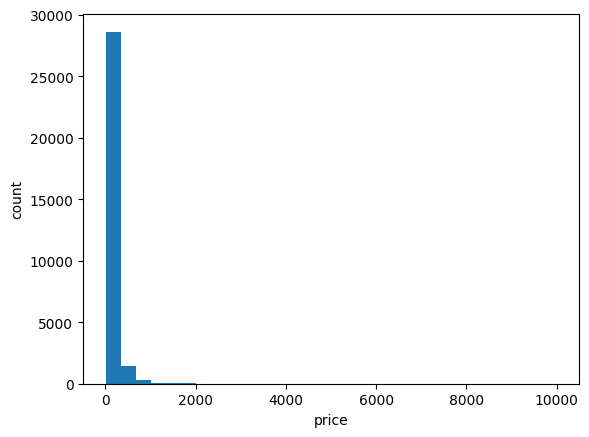

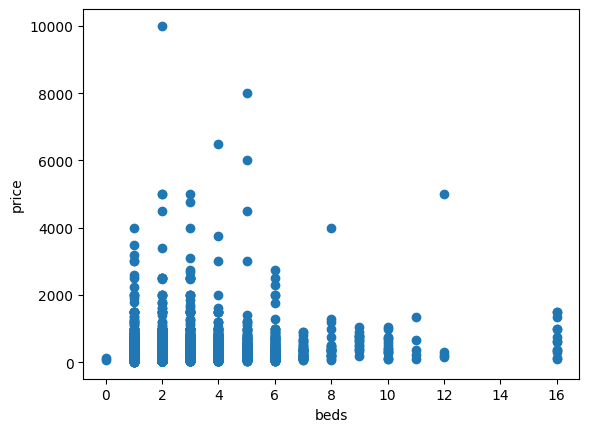

In [77]:
df['price'] = (
    df['price']
      .astype(str)                           # ensure it’s a string
      .str.replace(r'[\$,]', '', regex=True) # remove $ and commas
      .astype(float)
)


df['price_log'] = np.log1p(df['price'])




plt.hist(df['price'], bins=30)
plt.xlabel('price'); plt.ylabel('count')
plt.show()

plt.scatter(df['beds'], df['price'])
plt.xlabel('beds'); plt.ylabel('price')
plt.show()



In [78]:
# … your one‑hot and drop steps
drop_cols = ['host_id','name','host_since','zipcode']
X_train_clean = X_train.drop(columns=drop_cols, errors='ignore')
X_test_clean  = X_test .drop(columns=drop_cols, errors='ignore')

# At this point X_train_clean has NaNs in beds & review_scores_rating.
# Insert the imputation cell right here:


# 1) Drop the redundant _bin column (optional)
X_train_imp = X_train_clean.drop(columns=['review_scores_rating_bin'], errors='ignore')
X_test_imp  = X_test_clean .drop(columns=['review_scores_rating_bin'], errors='ignore')

# 2) Build & fit the imputer on train
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train_imp),
    columns=X_train_imp.columns,
    index=X_train_imp.index
)

# 3) Apply the same transformation to test
X_test_imp = pd.DataFrame(
    imputer.transform(X_test_imp),
    columns=X_test_imp.columns,
    index=X_test_imp.index
)

# 4) Quick sanity check
print("Nulls left in train:", X_train_imp.isna().sum().sum())
print("Nulls left in test: ", X_test_imp.isna().sum().sum())

# ——— end of imputation cell ———

# Now you can safely fit your model on the imputed data:

lr = LinearRegression()
lr.fit(X_train_imp, y_train)

y_pred = lr.predict(X_test_imp)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE:", rmse)
print("R²:  ", r2_score(y_test, y_pred))


Nulls left in train: 0
Nulls left in test:  0
RMSE: 182.1772385517171
R²:   0.20630251768464458


Step 4 results:
              train_rmse   test_rmse  train_r2   test_r2
numeric_only  185.973155  191.093776  0.100294  0.126707
all_features  176.754541  182.177239  0.187279  0.206303


/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/regressionplots.py:566: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()
<ipython-input-79-f0ac62b0239d>:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


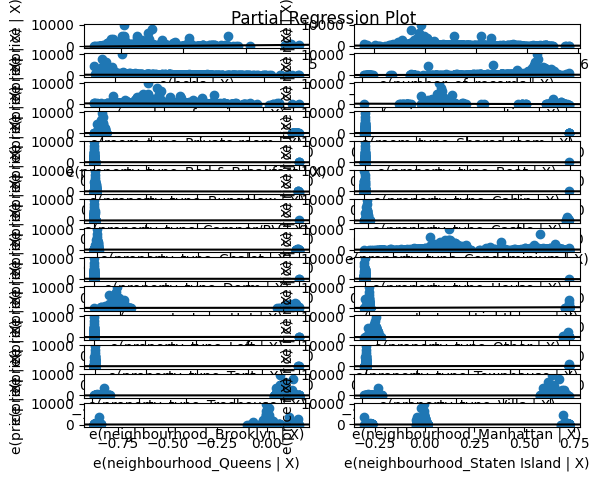


Step 6 comparison:
              train_rmse   test_rmse  train_r2   test_r2
numeric_only  185.973155  191.093776  0.100294  0.126707
all_features  176.754541  182.177239  0.187279  0.206303
complex       176.236898  182.044119  0.192033  0.207462

Step 8 Lasso results:
              train_rmse   test_rmse  train_r2   test_r2  \
numeric_only  185.973155  191.093776  0.100294  0.126707   
all_features  176.754541  182.177239  0.187279  0.206303   
complex       176.236898  182.044119  0.192033  0.207462   
lasso          176.90517  182.043928  0.185894  0.207464   

                                              selected_features  
numeric_only                                                NaN  
all_features                                                NaN  
complex                                                     NaN  
lasso         [beds, number_of_reviews, review_scores_rating...  


In [79]:

results = {}
feature_sets = {
    'numeric_only': ['beds', 'number_of_reviews', 'review_scores_rating'],
    'all_features': X_train_imp.columns.tolist()
}

for name, feats in feature_sets.items():
    lr = LinearRegression().fit(X_train_imp[feats], y_train)
    y_tr = lr.predict(X_train_imp[feats])
    y_te = lr.predict(X_test_imp[feats])
    results[name] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_tr)),
        'test_rmse':  np.sqrt(mean_squared_error(y_test,  y_te)),
        'train_r2':   r2_score(y_train, y_tr),
        'test_r2':    r2_score(y_test,  y_te)
    }

print("Step 4 results:")
print(pd.DataFrame(results).T)





X_sm = sm.add_constant(X_train_imp)
ols  = sm.OLS(y_train, X_sm).fit()
fig  = sm.graphics.plot_partregress_grid(ols)
fig.tight_layout()
plt.show()




num_feats = ['beds', 'number_of_reviews', 'review_scores_rating']
poly      = PolynomialFeatures(degree=2, include_bias=False)
Xp_train  = poly.fit_transform(X_train_imp[num_feats])
Xp_test   = poly.transform(X_test_imp[num_feats])
poly_cols = poly.get_feature_names_out(num_feats)


df_ptrain = pd.DataFrame(Xp_train, columns=poly_cols, index=X_train_imp.index)
df_ptest  = pd.DataFrame(Xp_test,  columns=poly_cols, index=X_test_imp.index)


other = [c for c in X_train_imp.columns if c not in num_feats]
Xc_train = pd.concat([df_ptrain, X_train_imp[other]], axis=1)
Xc_test  = pd.concat([df_ptest,  X_test_imp[other]],  axis=1)


lr2 = LinearRegression().fit(Xc_train, y_train)
y2_tr = lr2.predict(Xc_train)
y2_te = lr2.predict(Xc_test)

results['complex'] = {
    'train_rmse': np.sqrt(mean_squared_error(y_train, y2_tr)),
    'test_rmse':  np.sqrt(mean_squared_error(y_test,  y2_te)),
    'train_r2':   r2_score(y_train, y2_tr),
    'test_r2':    r2_score(y_test,  y2_te)
}

print("\nStep 6 comparison:")
print(pd.DataFrame(results).T)




lasso = LassoCV(cv=5, random_state=42).fit(X_train_imp, y_train)
coef  = pd.Series(lasso.coef_, index=X_train_imp.columns)
sel   = coef[coef != 0].index.tolist()

yL_tr = lasso.predict(X_train_imp)
yL_te = lasso.predict(X_test_imp)

results['lasso'] = {
    'train_rmse':         np.sqrt(mean_squared_error(y_train, yL_tr)),
    'test_rmse':          np.sqrt(mean_squared_error(y_test,  yL_te)),
    'train_r2':           r2_score(y_train, yL_tr),
    'test_r2':            r2_score(y_test,  yL_te),
    'selected_features':  sel
}

print("\nStep 8 Lasso results:")
print(pd.DataFrame(results).T[['train_rmse','test_rmse','train_r2','test_r2','selected_features']])
